 ### **A Metric to Explicitly Tell You When to Retrain a Machine Learning Model**

Blog: link.

- Application on Sintetic datasets

In [1]:
# Import libs
from holisticai.robustness.metrics.dataset_complexity import *

In [2]:
# Generate sintetic datasets

dataset_generators = [
    ("Make Moons", generate_moons),
    # ("Make Circles", generate_circles),
    # ("Make Classification", generate_classification),
    # ("Make Blobs", generate_blobs),
    # ("XOR", generate_xor),
    # ("Swiss Roll", generate_swiss_roll),
    # ("Gaussian Quantiles", generate_gaussian_quantiles),
    # ("Make Friedman 1", generate_friedman1),
    # ("Spirals", generate_spirals),
    ("Two Intertwined Spirals", generate_two_intertwined_spirals)
]

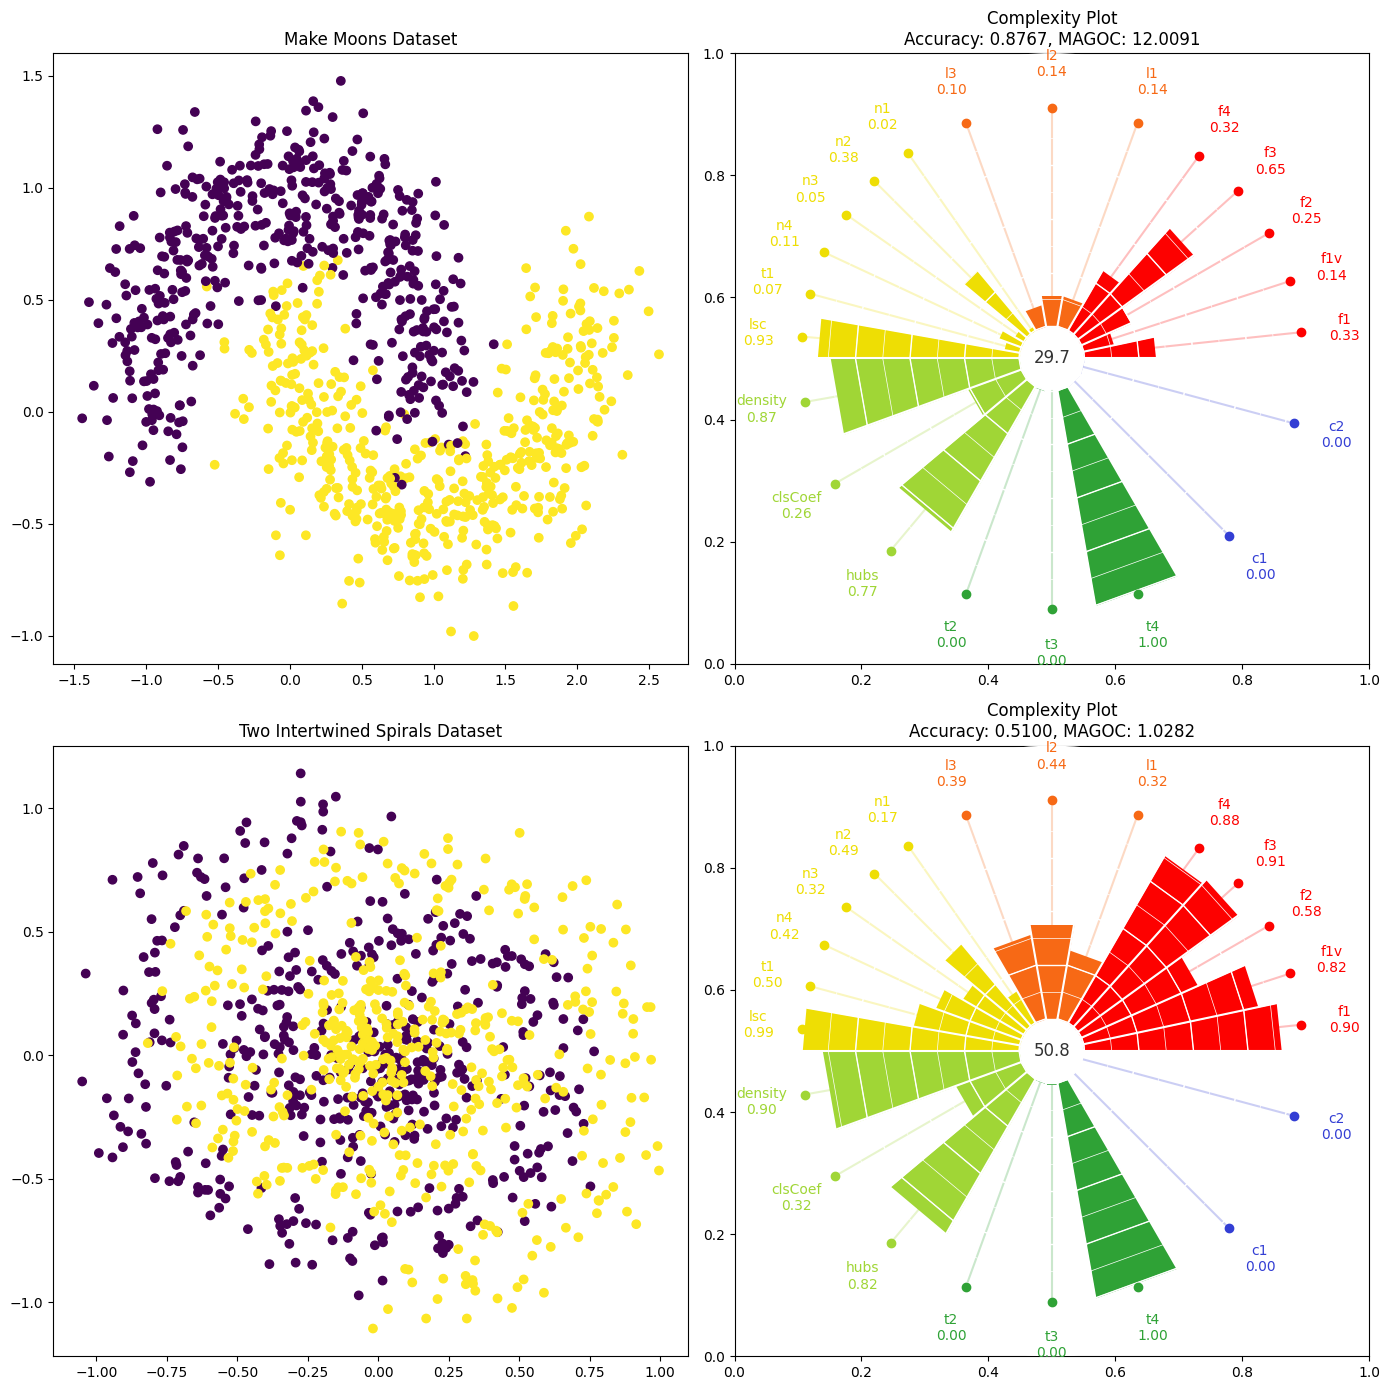

[{'name': 'Make Moons',
  'accuracy': 0.8766666666666667,
  't1': np.float64(0.073),
  'src': np.float64(12.009132420091326),
  'error': None},
 {'name': 'Two Intertwined Spirals',
  'accuracy': 0.51,
  't1': np.float64(0.496),
  'src': np.float64(1.028225806451613),
  'error': None}]

In [3]:
# Evaluate MAGOC on the datasets
evaluate_datasets(dataset_generators)

- Application on Real datasets

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from holisticai.robustness.metrics.dataset_complexity import *
from holisticai.datasets import load_dataset

# List of datasets
datasets = [
    "adult",
    "law_school",
    "student_multiclass",
    "us_crime_multiclass",
    "clinical_records",
    # New datasets
    "german_credit",
    "census_kdd",
    "bank_marketing",
    "compass",
    "diabetes",
    "acsincome",
    "acspublic"
]

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis()
}

# Initialize dictionaries to store complexities and accuracies
complexities_data = {}
accuracies_data = {model_name: [] for model_name in models.keys()}

for dataset_name in datasets:
    try:
        # Load dataset
        dataset = load_dataset(dataset_name)

        # Shrink the dataset to a maximum of 1000 rows
        n_rows = min(1000, dataset["X"].shape[0])
        X = dataset["X"].iloc[:n_rows, :]
        y = dataset["y"].iloc[:n_rows]

        # Standardize the data
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Split the dataset into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Initialize ComplexityCalculator
        cc = px.ComplexityCalculator()

        # Fit ComplexityCalculator with data
        cc.fit(X, y)

        # Extract complexities from the report
        complexities = cc.report()["complexities"]
        complexities_data[dataset_name] = complexities

        # Evaluate models on the dataset
        for model_name, model in models.items():
            try:
                # Train the model
                model.fit(X_train, y_train)

                # Predict on the test set
                y_pred = model.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)

                # Append accuracy for the model and dataset
                accuracies_data[model_name].append(accuracy)
            except Exception as e:
                # Append NaN if the model fails
                accuracies_data[model_name].append(float("nan"))
                print(f"Error with model {model_name} on dataset {dataset_name}: {e}")

    except Exception as e:
        # Handle dataset loading or processing errors
        print(f"Error processing dataset {dataset_name}: {e}")
        for model_name in models.keys():
            accuracies_data[model_name].append(float("nan"))

# Convert the complexities data into a DataFrame
complexities_df = pd.DataFrame(complexities_data)

# Convert the accuracies data into a DataFrame
accuracies_df = pd.DataFrame(accuracies_data, index=datasets).T

# Display the DataFrames
display("Accuracies DataFrame:")
display(accuracies_df)

# Extract the `t1` row from `complexities_df`
t1_series = complexities_df.loc["t1"]  # Extract t1 values for each dataset

# Divide accuracies_df by the T1
src_df = accuracies_df.div(t1_series, axis=1)

# MAGOC dataframe
print("The MAGOC metric by model and dataset:\n(values below 1.0 indicate that retraining the model on the dataset, if needed, is NOT recommended)")
display(src_df.dropna(axis=1))


/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/problexity/classification/feature_based.py:45: RuntimeWarning: invalid value encountered in divide
  r_all = l/m
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/problexity/classification/feature_based.py:141: RuntimeWarning: invalid value encountered in divide
  return np.nanprod(f_overlap/f_range)
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and w

Error processing dataset bank_marketing: 'float' object is not iterable
Error processing dataset compass: 


/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/problexity/classification/feature_based.py:45: RuntimeWarning: invalid value encountered in divide
  r_all = l/m
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/problexity/classification/feature_based.py:141: RuntimeWarning: invalid value encountered in divide
  return np.nanprod(f_overlap/f_range)
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/andrelfnovaes/.local/share/hatch/env/virtual/holisticai/OHrFrk2Z/testing/lib/python3.10/site-packages/problexity/classification/feature_based.py:45: RuntimeWarning: invalid value encountered in divide
  r_all = l/m

'Accuracies DataFrame:'

,adult,law_school,student_multiclass,us_crime_multiclass,clinical_records,german_credit,census_kdd,bank_marketing,compass,diabetes,acsincome,acspublic
Logistic Regression,0.806667,0.923333,0.512605,0.567568,0.777778,0.710000,0.920000,NaN,NaN,0.906667,0.930000,0.846667
Random Forest,0.800000,0.923333,0.521008,0.621622,0.755556,0.723333,0.940000,NaN,NaN,0.920000,0.943333,0.910000
Support Vector Machine,0.783333,0.920000,0.478992,0.594595,0.766667,0.693333,0.940000,NaN,NaN,0.920000,0.906667,0.876667
K-Nearest Neighbors,0.806667,0.906667,0.378151,0.513514,0.677778,0.710000,0.930000,NaN,NaN,0.903333,0.910000,0.863333
Decision Tree,0.760000,0.840000,0.478992,0.540541,0.677778,0.626667,0.930000,NaN,NaN,0.813333,0.923333,0.933333
Naive Bayes,0.363333,0.850000,0.504202,0.648649,0.722222,0.626667,0.750000,NaN,NaN,0.110000,0.913333,0.806667
Gradient Boosting,0.816667,0.910000,0.512605,0.567568,0.733333,0.693333,0.946667,NaN,NaN,0.913333,0.943333,0.893333
AdaBoost,0.813333,0.896667,0.436975,0.648649,0.755556,0.680000,0.930000,NaN,NaN,0.903333,0.930000,0.893333
Linear Discriminant Analysis,0.806667,0.923333,0.504202,0.540541,0.755556,0.710000,0.936667,NaN,NaN,0.903333,0.920000,0.836667


The MAGOC metric by model and dataset:
(values below 1.0 indicate that retraining the model on the dataset, if needed, is NOT recommended)


,acsincome,acspublic,adult,census_kdd,clinical_records,diabetes,german_credit,law_school,student_multiclass,us_crime_multiclass
Logistic Regression,6.000000,3.400268,1.383648,2.548476,1.107946,2.249793,1.209540,2.707722,0.52521,0.670884
Random Forest,6.086022,3.654618,1.372213,2.603878,1.076290,2.282878,1.232254,2.707722,0.53382,0.734777
Support Vector Machine,5.849462,3.520750,1.343625,2.603878,1.092118,2.282878,1.181147,2.697947,0.49077,0.702830
K-Nearest Neighbors,5.870968,3.467202,1.383648,2.576177,0.965495,2.241522,1.209540,2.658847,0.38745,0.606990
Decision Tree,5.956989,3.748327,1.303602,2.576177,0.965495,2.018197,1.067575,2.463343,0.49077,0.638937
Naive Bayes,5.892473,3.239625,0.623213,2.077562,1.028807,0.272953,1.067575,2.492669,0.51660,0.766724
Gradient Boosting,6.086022,3.587684,1.400800,2.622345,1.044634,2.266336,1.181147,2.668622,0.52521,0.670884
AdaBoost,6.000000,3.587684,1.395083,2.576177,1.076290,2.241522,1.158433,2.629521,0.44772,0.766724
Linear Discriminant Analysis,5.935484,3.360107,1.383648,2.594645,1.076290,2.241522,1.209540,2.707722,0.51660,0.638937
